In [1]:
import openvino as ov
import numpy as np
import sys
import cv2
from PIL import Image
from matplotlib.patches import Circle
import matplotlib.pyplot as plt

In [2]:
core = ov.Core()

In [3]:
model = core.read_model(model="./human-pose-estimation.xml")
compiled_model = core.compile_model(model=model, device_name="CPU")

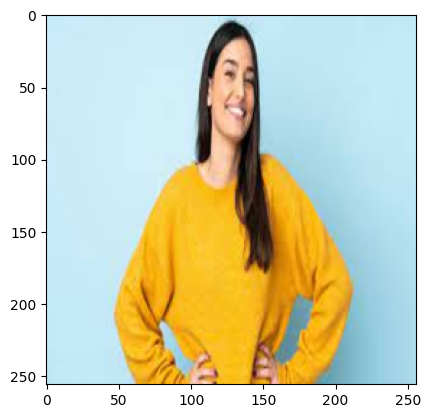

In [4]:
infer_request = compiled_model.create_infer_request()

image = Image.open("./Unknown.jpeg")
image = image.resize((256, 256))
image.load()
image = np.asarray(image, dtype=np.float32)

image = np.expand_dims(image, axis=0)
image = np.ascontiguousarray(np.transpose(image, (0, 3, 1, 2)))

temp = np.squeeze(image, axis=0)
temp = np.transpose(temp, (1, 2, 0))
plt.imshow(np.uint8(temp))

input_tensor = ov.Tensor(array=image, shared_memory=True)
infer_request.set_input_tensor(input_tensor)

In [5]:
infer_request.start_async()
infer_request.wait()

In [6]:
output = infer_request.get_output_tensor()
output_buffer = output.data

In [7]:
output_buffer = np.squeeze(output_buffer, axis=0)
output_buffer = np.transpose(output_buffer, axes=(1, 2, 0))
heatmaps = cv2.resize(
    output_buffer, (256, 256), fx=8, fy=8, interpolation=cv2.INTER_CUBIC
)

In [8]:
def extract_keypoints(heatmap, min_confidence=-100):
    ind = np.unravel_index(np.argmax(heatmap, axis=None), heatmap.shape)
    if heatmap[ind] < min_confidence:
        ind = (-1, -1)
    else:
        ind = (int(ind[1]), int(ind[0]))
    return ind

In [9]:
keypoints = []
for kpt_idx in range(16):
    keypoints.append(extract_keypoints(heatmaps[:, :, kpt_idx]))

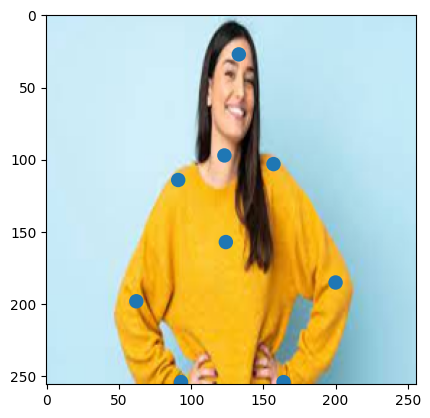

In [10]:
kpt_names = [
    "r_ank",
    "r_kne",
    "r_hip",
    "l_hip",
    "l_kne",
    "l_ank",
    "pel",
    "spi",
    "nec",
    "hea",
    "r_wri",
    "r_elb",
    "r_sho",
    "l_sho",
    "l_elb",
    "l_wri",
]
colors = [
    (255, 0, 0),
    (255, 0, 0),
    (255, 0, 0),
    (0, 0, 255),
    (0, 0, 255),
    (0, 0, 255),
    (0, 255, 0),
    (0, 255, 0),
    (0, 255, 0),
    (0, 255, 0),
    (255, 0, 0),
    (255, 0, 0),
    (255, 0, 0),
    (0, 0, 255),
    (0, 0, 255),
    (0, 0, 255),
]

fig, ax = plt.subplots(1)
ax.set_aspect("equal")

image = np.squeeze(image, 0)
image = np.transpose(image, (1, 2, 0))
ax.imshow(np.uint8(image))

for id in range(7, 16):
    keypoint = keypoints[id]
    if keypoint[0] != -1:
        ax.add_patch(Circle((int(keypoint[0]), int(keypoint[1]))))